# Modulation Classification Using SNNs based on the ESBP Algorithm

The code is based on the paper by 2020,Chankyu Lee et.all, <i>Enabling Spike-Based Backpropagation for Training Deep Neural Network Architecture</i>

In [224]:
import torch 
import torch.nn
import matplotlib.pyplot as plt 
import pickle
import h5py
import time as tm 
#%matplotlib inline
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input, LIFNodes, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor
from bindsnet.analysis.plotting import plot_spikes, plot_voltages, plot_weights
from bindsnet.learning import PostPre
from bindsnet.analysis.visualization import summary, plot_spike_trains_for_example, plot_voltage
from bindsnet import encoding
from tqdm import tqdm

In [225]:
#check cuda availibilty
device = 'cpu' if torch.cuda.is_available() else 'cpu'
print("We are using the following device for learning:",device)

We are using the following device for learning: cpu


## 0.  Define the helper's functions used in SNNs


In [226]:
def aux_spike_activity(spike, ref_spike,tmp = 100,T=100,isPlot = True):
    '''
    calculate the continous real value spike activity based on the equation 4
    from paper Lee.et.al (2016)
    output : tensor/vector of accumulated effects of spike at the final observation time T
    input  : spike, spike activity representd in 1 or 0
    input  : ref_spike, the reference function to save computational time
    input  : tmp, time constant of decaying spike signal
    input  : T, observation time
    '''
    dt = torch.linspace(0,T-1,T) #the time axis
    xk   = torch.zeros(spike.shape) #variable to store continous real value of accummulated. spike signal    
    
    """ if (ref_spike == None):
        y = torch.exp(-dt/tmp)
    else:
        y = ref_spike    """
    y = ref_spike
    sidx = (spike).nonzero().numpy() #get the index of the spike

    # plot the binary spike activity
    if isPlot:        
        spikes = {"A":spike}
        plt.figure()
        plot_spikes(spikes)

    # calculate the accumulated spike activity    
    for id,val in enumerate(sidx):
        if val[0]==0:
            xk[:,val[1]] = np.add(xk[:,val[1]],y)
        else:
            xk[:,val[1]] = np.add(xk[:,val[1]],[*np.zeros(val[0]),*y[0:-val[0]]])
    xk = -1*xk / tmp
    # plot the spike signal
    if isPlot:      
        plt.figure(figsize=[10,5])
        plt.plot(dt,xk)
        plt.title("Accumulated spike activity")
        plt.xlabel("Time Steps")
        #put some legend :)
        list_legend = []
        for i in range(spike.size(1)):
            list_legend.append('neuron %s'%i)
        plt.legend((list_legend),loc='best')
        plt.show()
    # return the last value of accum spike activity    
    return xk[-1,:]

def encode_increase_sr(datum: torch.Tensor, time: int, dt: float = 1.0)-> torch.Tensor:
    '''
    input : rate, spike rate (number of spike per second)
    input : time, length of spike train
    return : tensor with dimension [nk,ni]
    '''
    assert (datum >= 0).all(), "Inputs must be non-negative"
    #check if the datum is less than number of bins
    #if (datum.all() < time)

    # Get shape and size of data.
    shape, size = datum.shape, datum.numel()
    datum = datum.flatten()
    time = int(time / dt)
    
    spike_cr = torch.zeros(time,size).byte() #spike train
    dist_max = np.round(time/datum)
    #distance between spike
    dist_incr = dist_max / datum
    #print(dist_incr)
    #print(dist_max)
    
    for i,val in enumerate(dist_incr):
        idx_sp = torch.arange(datum[i].item() + 1) * val#spike index
        idx_sp = np.ceil(idx_sp)
        times = torch.cumsum(idx_sp,dim=0)   
        spike_cr[times.long(),i]=1

    return spike_cr.view(time,*shape)

def encode_increase_sr_2(datum: torch.Tensor, time: int, dt: float = 1.0)-> torch.Tensor:
    '''
    input : rate, spike rate (number of spike per second)
    input : time, length of spike train
    return : tensor with dimension [nk,ni]
    '''
    assert (datum >= 0).all(), "Inputs must be non-negative"
    # Get shape and size of data.
    shape, size = datum.shape, datum.numel()
    datum = datum.flatten()
    time = int(time / dt)

    spike_cr = torch.zeros(time+1,size).byte() #spike train
    dist_max = (time/(datum-1))
    for i,val in enumerate(dist_max):
        dist_incr = torch.arange(datum[i].item()) * (val/(datum[i]-1))        
        times = np.round(torch.arange(datum[i].item()) * dist_incr)
        spike_cr[times.long(),i]=1    
    
    return spike_cr[1:].view(time,*shape)


## 1. Build the SNNs to carry out the task of Amplitude Modulation detection

In [4]:
#load the weight
#output the file into a variable
""" filename = 'saved_weight_snn_4QAM_40HL_10dB_96prcnt'
infile = open(filename,'rb')
load_weight  = pickle.load(infile) """


In [227]:
#define the number of neuron in each layer
nodes = [2,40,4]

Time = 100 #training and inference time duration for each example
tau_m = 100 #time constant
T_ref = 1 #refractory period of neuron
delta_v = [3,55]
v_rest = -65
V_th =[-62,-10] #voltage threshold of neuron
V_th1 = V_th[0]+torch.zeros(1,nodes[1]) #voltage threshold for hidden layer 
V_th2 = V_th[1]+torch.zeros(1,nodes[2]) #voltage threshold for hidden layer
k = 2 #weight initialization constant

#define the network object
network = Network()

#define the type of layer
source_layer = Input(n=nodes[0],traces=False)
hidden_layer = LIFNodes(n=nodes[1],trace=False,refrac=T_ref,thresh=V_th1,tc_decay=tau_m,sum_input=False,lbound=v_rest - delta_v[0])
target_layer = LIFNodes(n=nodes[2],traces=False,refrac=T_ref,thresh=V_th2,tc_decay=tau_m,sum_input=False,lbound=v_rest - delta_v[1])
#adding layer to the network
network.add_layer(
    layer = source_layer, name="A"
)
network.add_layer(
    layer = hidden_layer, name="B"
)
network.add_layer(
    layer = target_layer, name="C"
)

#define the connection for each layer
#create a connection between input and hidden layers
forward_connection1 = Connection(
    source = source_layer,
    target= hidden_layer,
    #weight initialization according to Lee et.al 
    w = (torch.normal(mean=0,std=np.sqrt(1/(nodes[0]+5)),size=(source_layer.n, hidden_layer.n)))    
    #w = load_weight["hid"]
)
network.add_connection(
    connection=forward_connection1, source="A", target="B"
)
#create a connection between hidden layer and output layer
forward_connection2 = Connection(
    source = hidden_layer,
    target = target_layer,
    #weight initialization according to Lee et.al    
    w = (torch.normal(mean=0,std=np.sqrt(k/nodes[1]),size=(hidden_layer.n, target_layer.n)))    
    #w = torch.abs((torch.normal(mean=0,std=np.sqrt(k/nodes[1]),size=(hidden_layer.n, target_layer.n))))     #absolute
    #w = load_weight["out"]
)
network.add_connection(
    connection=forward_connection2, source="B", target="C"
)

#create and add input and output layer monitor
source_monitor = Monitor(
    obj = source_layer,
    state_vars = ("s",), #record spikes and voltages
    time = Time , 
)
hidden_monitor = Monitor(
    obj = hidden_layer,
    state_vars=("s","v"),
    time = Time ,
)
target_monitor = Monitor(
    obj = target_layer,
    state_vars= ("s", "v"),
    time = Time ,
)
#add the monitor to the network
network.add_monitor(monitor=source_monitor, name="A")
network.add_monitor(monitor=hidden_monitor, name="B")
network.add_monitor(monitor=target_monitor, name="C")

#network.cuda(device)

## 2.a Generate 4-AM Dataset

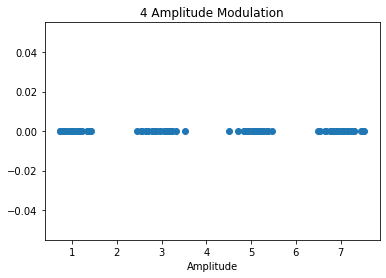

In [228]:
#generate the data 4 level of amplitude modulation
M = 4 #number of amplitude level
N_samples = 100 #number of training sample

s = np.random.randint(M, size= N_samples) #generate N random symbols

c = s * 2 + 1 #assign symbol to a certain amplitude level
n = np.random.normal(0,0.25,N_samples) #random gaussian noise
z = c + n #signal plus noise

#convert to torch tensor
s = torch.from_numpy(s)
z = torch.from_numpy(z)
#plot
y_ax = np.zeros(N_samples)
plt.scatter(z,y_ax)
plt.title('%d Amplitude Modulation'%M)
plt.xlabel('Amplitude')
plt.show()

## 2.b Generate M-QAM & PSK Datasets


In [230]:
#generate 4 level quadrature amplitude modulation
M =  4
N_samples = 100

#QAM modulation format
qam = [ ( 2 * m - int(np.sqrt( M ) ) + 1 ) * 1  + 1j * ( 2 * n - int(np.sqrt( M ) ) + 1  ) for m in range( int(np.sqrt( M ) )) for n in range( int(np.sqrt(M) )) ]
qam /= np.linalg.norm( qam ) / np.sqrt( M )
#PSK modulation format
psk = [ -np.exp( 1j * 2 * np.pi * m / M + 1j * np.pi / M ) for m in range( M ) ]

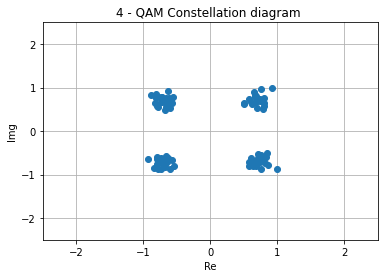

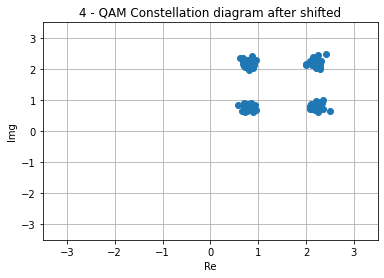

In [232]:

#define the noise power
SNR_dB = 18 # the SNR Value in dB
sigma2_n = 1**2 * 10**( - SNR_dB / 10 ) # get the noise variance

c = np.zeros(N_samples) + 1j*np.zeros(N_samples)
#generate the signal and add the effect of the noise
s = np.random.randint(M, size= N_samples) #generate N number of symbols

for i,val in enumerate(s):#assign symbol to certain constellation signal
    c[i] = qam[val] #change this to choose between psk and qam modulation scheme

n = np.random.randn( N_samples ) + 1j * np.random.randn( N_samples ) #complex noise
z = c + np.sqrt( sigma2_n / 2)*n
#z = z + (1 + 1j)
#convert to torch tensor
s = torch.from_numpy(s)
z = torch.from_numpy(z)
#plot
plt.plot( np.real( z ), np.imag( z ), '.', markersize = 12  )
plt.xlim( (-2.5, 2.5) )
plt.ylim( (-2.5, 2.5) )
plt.title('%d - QAM Constellation diagram '%M)
plt.xlabel('Re')
plt.ylabel('Img')
plt.grid(True)  
plt.show()
#plot after the points are shifted to the 1st quadrant
plt.plot( np.real( z )+1.5, np.imag( z )+1.5, '.', markersize = 12  )
plt.xlim( (-3.5, 3.5) )
plt.ylim( (-3.5, 3.5) )
plt.title('%d - QAM Constellation diagram after shifted'%M)
plt.xlabel('Re')
plt.ylabel('Img')
plt.grid(True)  
plt.show()


### 2.1 Convert the Amplitude Modulation Datasets into spike train
Each amplitude level is converted into poisson distributed spike train. The spike rate of each train is determined <br> 
by the amplitude level. It is intentionally to make the final layer does not output any spike by setting voltage <br>
threshold to be very high. The classification instead is carried out by calculating the internal voltage of the neuron.

elapsed time for one forward propagation 67.4338  ms


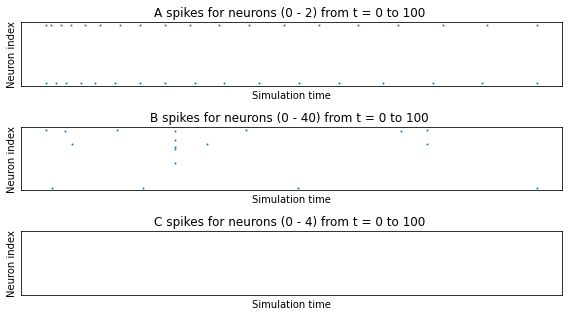

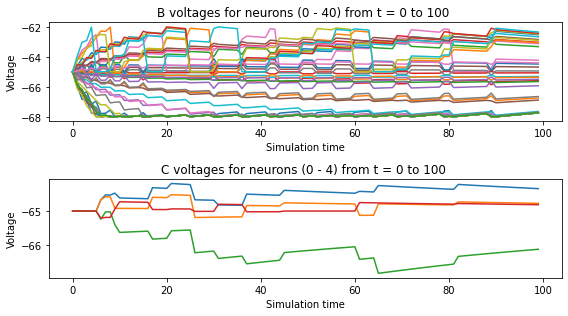

In [235]:
network.layers["C"].reset_state_variables() #reset neuron internal voltage
network.layers["B"].reset_state_variables() #reset neuron internal voltage   
#convert all the amplitude data into the spike rate
mod_type = "cplx"

max_rate = 25 #maximum rate in Hz poisson 400
rate = torch.zeros(z.shape)
input_data = torch.zeros(N_samples*Time,nodes[0],device=device)


for i,val in enumerate(z):
    #print(i,val,y[i])
    if (nodes[0]==1): #check if the input is one
        rate = torch.tensor([val*max_rate]).squeeze()
        input_data[i*Time:(i*Time)+Time,0] = encoding.poisson(datum=rate.int(),time=Time) 
    if (mod_type=="cplx"):
        rate = torch.tensor([[(np.real(val)+1.5)*max_rate],[(np.imag(val)+1.5)*max_rate]]).squeeze()              
        #convert into poisson distributed spike train
        #input_data[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 
        input_data[i*Time:(i*Time)+Time,:] = encode_increase_sr_2(datum=rate.int(),time=Time) 
    else:
        rate = torch.tensor([[val*max_rate],[(2*M-val)*max_rate]]).squeeze() #convert amplitude to spike rate
        #convert into poisson distributed spike train
        input_data[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 

y = torch.nn.functional.one_hot(torch.tensor(s,device=device))  #convert label to one hot encoding

#feed the input spike train into the network
#run the network
j = np.random.choice(N_samples) #randomly choose the index of input data
j = 44

start_time = tm.time_ns()

inputs = {'A':input_data[j*Time:(j*Time)+Time,:]}
network.run(inputs=inputs , time=Time)
#record spike activity and neuron voltage
end_time = tm.time_ns()
spikes = {
    "A": network.monitors['A'].get('s'), 
    "B": network.monitors['B'].get("s"),
    "C": network.monitors['C'].get("s"),
}
voltages = {"B": network.monitors['B'].get("v"),
            "C": network.monitors['C'].get("v")}

print("elapsed time for one forward propagation %1.4f  ms"%((end_time-start_time)/1e6))

#plot the result
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()
#reset the voltage neuron
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()    

In [236]:
#print the number of input spike at each input neuron
for i in range(N_samples):
    sample_data = input_data[i*Time:(i*Time)+Time,:]
    if (nodes[0]==1):
        print('sample %d, sent symbol %d, total spikes : %d '%(i,s[i],sum(sample_data[:,0]).item()))
    else:        
        print('sample %d, sent symbol %d,  total spikes : %d ; %d'%(i,s[i],sum(sample_data[:,0]).item(),sum(sample_data[:,1]).item()))
    #print(sum(sample_data[:,0]).item())
    #print(sum(sample_data[:,1]).item())


sample 0, sent symbol 0,  total spikes : 18 ; 14
sample 1, sent symbol 3,  total spikes : 42 ; 45
sample 2, sent symbol 0,  total spikes : 15 ; 19
sample 3, sent symbol 2,  total spikes : 44 ; 19
sample 4, sent symbol 1,  total spikes : 20 ; 47
sample 5, sent symbol 2,  total spikes : 47 ; 22
sample 6, sent symbol 0,  total spikes : 13 ; 19
sample 7, sent symbol 0,  total spikes : 17 ; 18
sample 8, sent symbol 2,  total spikes : 49 ; 22
sample 9, sent symbol 0,  total spikes : 18 ; 15
sample 10, sent symbol 3,  total spikes : 45 ; 50
sample 11, sent symbol 3,  total spikes : 47 ; 51
sample 12, sent symbol 3,  total spikes : 44 ; 45
sample 13, sent symbol 2,  total spikes : 46 ; 18
sample 14, sent symbol 1,  total spikes : 21 ; 45
sample 15, sent symbol 2,  total spikes : 45 ; 15
sample 16, sent symbol 0,  total spikes : 21 ; 15
sample 17, sent symbol 2,  total spikes : 48 ; 19
sample 18, sent symbol 3,  total spikes : 48 ; 43
sample 19, sent symbol 1,  total spikes : 20 ; 43
sample 20,

## 3. Train The Network using Spike-Based Gradient Descent Backpropagation Algorithm

the following are the procedure to do Backpropagation Algorithm <br>
1. Forward propagation the input train spike into the Network <br>
2. Backward propagate the error from last layer to hidden layer <br>
3. Update the weights based on the errror gradient <br>


In [119]:


dt = torch.linspace(0,Time-1,Time) #the time axis
ref_spike = torch.exp(-dt/tau_m).to(device) ##spike referrence

num_epoch = 100 #number of epochs
learn_rate = 0.05 #the learning rate
L = torch.zeros(num_epoch)
l = torch.zeros(N_samples)
ACC = torch.zeros(num_epoch)
y_pred = torch.zeros(N_samples)
#l = 0

#the learning loop
for epoch in range(num_epoch): #loop for every epochs    
    start_time = tm.time_ns()
    for sample in tqdm(range(N_samples)): #loop for every training sample
        #1. run forward propagation         
        inputs = {"A":input_data[sample*Time:(sample*Time)+Time,:]} #fetch the training sample
        label = y[sample,:] #fetch the correct label for the training sample
        network.run(inputs=inputs,time=Time)
        #   1.1 get the spikes and voltages information
        spikes = {
            "A": network.monitors['A'].get("s"), #spike activity at the input layer 
            "B": network.monitors['B'].get("s"), #spike activit at the hidden layer
            #"C": network.monitors['C'].get("s"),
            }
        """ voltages = {
            "B": network.monitors['B'].get("v"),#voltage neuron at hidden layer
            "C": network.monitors['C'].get("v")}#voltage neuron at output layer """
        # get the weights of the network
        w_hid = network.connections['A','B'].w          
        w_out = network.connections['B','C'].w
        gamma = torch.sum(spikes['B'].squeeze(),dim=0).float() #number of spikes train in each neuron in hidden layer outputting
        #   1.2 calculate total weighted sum of pre and post spike at hidden layer
        net_hid = torch.sum (w_hid *(torch.sum(spikes['A'])),dim=0)  #accumulated input current at hidden layer
        a_lif_hid = torch.sum(spikes['B'].squeeze(),dim=0).float()   #activation of neuron/output spi

        #   1.3 calculate total weighted sum of pre and spike trains at the output layer
        net_out = (a_lif_hid @ w_out) #accumulated input current at output layer
        #a_lif_out = (network.layers['C'].v ) #output at the last layer (cross entropy) voltage
        a_lif_out = torch.softmax(network.layers['C'].v,dim=1) #output at the last layer (cross entropy) voltage
        #print(a_lif_out)
       
        #2. Calculate the Backward Propagation
        # At the output layer
        e_out = a_lif_out - label #error at the output layer
        delta_e_out = e_out / Time  #error gradient at the output layer
        
        #calculate loss function
        l[sample] = 0.5 * torch.sum(e_out**2)
        #calculate accuracy
        #y_pred[sample] = torch.argmax(a_lif_out)
        y_pred[sample] = torch.argmax(network.layers['C'].v) #classification is carried out by determining which neuron has the maximum membrane potential

        #at the hidden layer

        ############ this code needs to be optimize,it took 35ms to run#######################################################################
        f_prime = aux_spike_activity(spikes['B'].squeeze(), ref_spike,tmp = tau_m,T=Time,isPlot = False) #calculate the spike leak activity
        ############ this code needs to be optimize ######################################################################################

        leak_correct = (1 +  (1/gamma)*f_prime)
        da_lif_hid = (1/network.layers['B'].thresh) * leak_correct
        delta_e_hid = (w_out @ delta_e_out.T) * da_lif_hid.T #error gradient at hidden layer
        delta_e_hid[torch.where(torch.isnan(delta_e_hid)==True)] = 0
        

        #3. Update the weights
        #update_weights()
        X_out = torch.sum(spikes['B'],dim=0).float()
        X_hid = torch.sum(spikes['A'],dim=0).float()
        delta_w_out = -learn_rate * (X_out.T @ delta_e_out)     #gradient of weigth at the output layer 
        delta_w_hid = -learn_rate * (X_hid.T @ delta_e_hid.T)   #gradient of weight at the hidden layer

        w_out.add_(delta_w_out)
        w_hid.add_(delta_w_hid) 
        
        #4.reset the membrane potential in the network
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()  
    
    end_time = tm.time_ns()
    el_time = (end_time - start_time) * 1e-6
    L[epoch] = torch.sum(l)/N_samples
    ACC[epoch] = (torch.sum(y_pred==s)*100)/N_samples
    #print epochs and loss
    print("epochs %d, time@epoch %1.2f ms, loss=%f, acc= %1.2f %%,  "%(epoch,el_time,L[epoch].item(),ACC[epoch].item()))
    #if (L[epoch] < 0.025) or (ACC[epoch] > 99.0):
    if (L[epoch] < 0.015):
        break #stop the loop


100%|██████████| 100/100 [00:11<00:00,  8.75it/s]epochs 99, time@epoch 11433.93 ms, loss=0.039044, acc= 100.00 %,  



# 4. Run The Final Prediction
After the training, feed the data into the network to make final Prediction

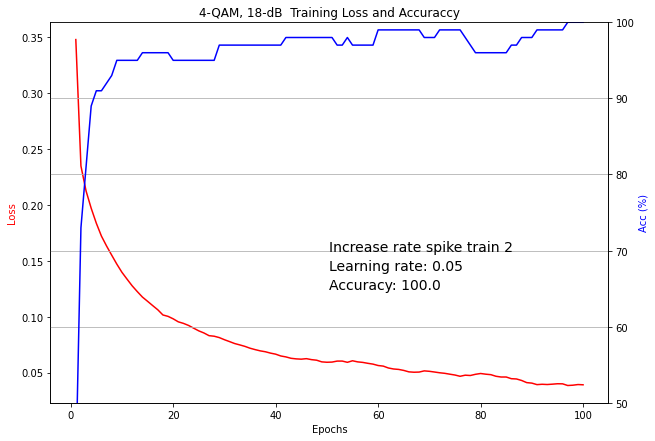

In [120]:
#plot the loss and accuracy every iteration
""" 
plt.figure(figsize=[10,7])
plt.plot(x_ax,L)
plt.plot(x_ax,ACC)
plt.title("4-QAM Training Loss in each iteration, batch = %s"%N_samples)
plt.ylabel("Loss",)
plt.xlabel("epochs") """

##
x_ax = np.linspace(1,len(L),len(L))

fig = plt.figure(figsize=[10,7])
ax1 = fig.add_subplot(111)
#line plot of loss
line1, = ax1.plot(x_ax,L,'r',label='Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss',color='r')
#create share axis
ax2 = ax1.twinx()
#line plot of accuracy
line2, = ax2.plot(x_ax,ACC,'b',label='Accuracy')
ax2.set_ylabel('Acc (%)',color='b')
#add legend
#plt.legend((),())
plt.title("4-QAM, %d-dB  Training Loss and Accuraccy"%(SNR_dB))
plt.text(0.5,0.4,s='Increase rate spike train 2',transform=ax1.transAxes,fontsize = 14)
plt.text(0.5,0.35,s='Learning rate: %.2f'%(learn_rate),transform=ax1.transAxes,fontsize = 14)
plt.text(0.5,0.3,s='Accuracy: %.1f '%(max(ACC)),transform=ax1.transAxes,fontsize = 14)
plt.grid(which='both')
plt.ylim(50,100)
plt.show()

In [121]:
#save the weight of trained network
""" saved_weight_4AM = {'out':w_out,
                    'hid':w_hid}

filename = 'saved_weight_snn_4QAM_40HL_18dB_100prcnt'
outfile = open(filename, 'wb')
pickle.dump(saved_weight_4AM,outfile)
outfile.close()  
print('saved success !')           
             """

saved success !


## 4.1 Run forward propagation, determine the class output by calculating neuron's membrane voltage

In [137]:
#acc_train_v = []

In [163]:
#set the membrane voltage threshold 
network.layers["C"].thresh = -10 * torch.ones(nodes[2])
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()

#run the final prediction
y_pred_run = torch.zeros(N_samples)
for j in range(N_samples):
    inputs = {"A":input_data[j*Time:(j*Time)+Time,:]}
    network.run(inputs=inputs,time=Time)
    #fetch the spikes and voltage value
    spikes = {
        "A": network.monitors['A'].get('s'), 
        "B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
    voltages = {#"B": network.monitors['B'].get("v"),
                "C": network.monitors['C'].get("v")}    

    '''
    if (j==49):#select random data to plot
        #plot the result
        plt.ioff()
        plot_spikes(spikes)
        plot_voltages(voltages, plot_type="line")
        plt.show()
    '''
    #check membrane voltage at the last layer    
    a_out = (network.layers['C'].v)    
    #print(a_out)
    y_pred_run[j] = torch.argmax(a_out)
    #print(y_pred_run[j])
    #print(torch.abs(a_otrainut-torch.max(a_out)))
    #reset state variables 

    #plot all output layer's voltage when classification is correct
    '''
    if(y_pred_run[j]==s[j]):
        plt.ioff()
        plot_voltages(voltages,plot_type="line")
        plt.show()
    '''
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

#print("Output final layer ",y_pred_run) 
#print("target vector %s"%s)
#calculate accuracy
accr = (torch.sum(y_pred_run==s)*100/N_samples)
print("Accuracy : "+str(accr.item())+" % ")
acc_train_v.append(accr)
print(acc_train_v)

Accuracy : 100.0 % 
[tensor(97.), tensor(99.), tensor(98.), tensor(100.), tensor(99.), tensor(100.), tensor(99.), tensor(100.)]


In [123]:
#check the dataset where misclassification happened
idx = (y_pred_run == s)
idx_mis = (idx == False).nonzero()
#print(idx_mis)
print(idx_mis)
print('True Label ',s[idx_mis].squeeze()) #training sample
print('Prediction ',y_pred_run[idx_mis].squeeze().int())#predicted by the network#

tensor([], size=(0, 1), dtype=torch.int64)
True Label  tensor([], dtype=torch.int64)
Prediction  tensor([], dtype=torch.int32)


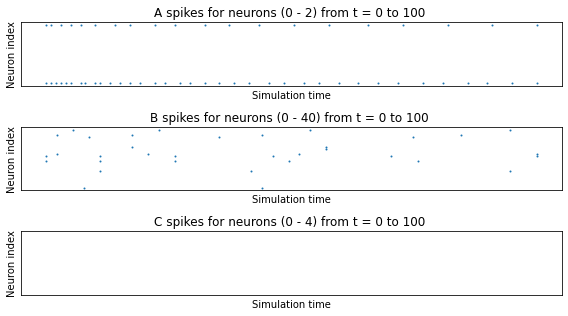

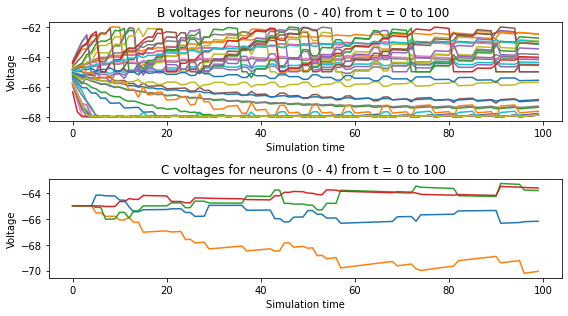

tensor([[-66.1910, -70.0478, -63.8220, -63.6332]])


In [23]:
#plot the spike activity and membrane voltage of the misclassified dataset
#reset state variables 
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()

j = idx_mis[0]
inputs = {"A":input_data[j*Time:(j*Time)+Time,:]}
network.run(inputs=inputs,time=Time)
#fetch the spikes and voltage value
spikes = {
        "A": network.monitors['A'].get('s'), 
        "B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
voltages = {"B": network.monitors['B'].get("v"),
                "C": network.monitors['C'].get("v")}
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()                

print(voltages["C"][99,:,:])


## 4.2 Run forward propagation, determine the class output by calculating the number of spike generated at the output layer

In [216]:
#try for every voltage threshold
delta_v = torch.linspace(v_rest+1,-60,9)
accuracy_vs = torch.zeros(delta_v.shape)  #accuracy by determining first neuron to spike
accuracy_vs_2 =torch.zeros(delta_v.shape) #accuracy by calculating number of spike
print(delta_v)

for i,val in enumerate(delta_v):
    #set the voltage threshold
    network.layers["C"].thresh = val * torch.ones(nodes[2])
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()
    #loop every examples
    y_pred_run = torch.zeros(N_samples)
    for j in range(N_samples):
    
        #fetch the input data
        inputs = {"A":input_data[j*Time:(j*Time)+Time,:]} 
        #run the forward propagation with input data
        network.run(inputs=inputs,time=Time)  
        spikes = {            
            "C": network.monitors['C'].get("s"),
        }

        #fetch the spike signal at the output layer
        a_out = torch.sum(network.monitors['C'].get("s").squeeze(),dim=0)
        
        #determine the coresponding class
        #y_pred_run[j] = torch.argmax(a_out,dim=0) # determine the class by observing which neuron to generate more spike
        #check if the output spike have the same number of spike
        
        if(sum(a_out)==0):
            y_pred_run[j] = torch.argmax(a_out,dim=0)
        else:    
            y_pred_run[j] = (spikes["C"].squeeze().int()==1).nonzero()[0,1] #determine the class by observing which neuron to spike first
        
        #reset state variables 
        network.layers["C"].reset_state_variables()
        network.layers["B"].reset_state_variables()
    
    #calculate accuracy    
    accuracy_vs[i] = (torch.sum(y_pred_run==s)*100/N_samples)
    print("Threshold "+str(delta_v[i].item())+"Accuracy : "+str(accuracy_vs[i].item())+" % ")



tensor([-64.0000, -63.5000, -63.0000, -62.5000, -62.0000, -61.5000, -61.0000,
        -60.5000, -60.0000])
Threshold -64.0Accuracy : 20.0 % 
Threshold -63.5Accuracy : 30.0 % 
Threshold -63.0Accuracy : 54.0 % 
Threshold -62.5Accuracy : 100.0 % 
Threshold -62.0Accuracy : 100.0 % 
Threshold -61.5Accuracy : 100.0 % 
Threshold -61.0Accuracy : 73.0 % 
Threshold -60.5Accuracy : 62.0 % 
Threshold -60.0Accuracy : 51.0 % 


Text(0, 0.5, 'Accuracy (%)')

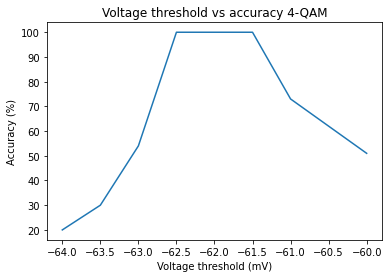

In [217]:
#plot inference accuracy vs. voltage threshold
plt.plot(delta_v,accuracy_vs)
plt.title("Voltage threshold vs accuracy 4-QAM")
plt.xlabel("Voltage threshold (mV)")
plt.ylabel("Accuracy (%)")

In [218]:
print(torch.max(accuracy_vs))
acc_train_s.append(torch.max(accuracy_vs))
print(acc_train_s)

tensor(100.)
[tensor(94.), tensor(98.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.), tensor(100.)]


In [127]:
#set the membrane voltage threshold with some small value from v_rest
network.layers["C"].thresh = delta_v[torch.argmax(accuracy_vs)] * torch.ones(nodes[2])
#reset state variables 
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()


#run the final prediction
y_pred_run = torch.zeros(N_samples)
for j in range(N_samples):
    #fetch the input data
    inputs = {"A":input_data[j*Time:(j*Time)+Time,:]} 
    #run the forward propagation with input data
    network.run(inputs=inputs,time=Time)           

    spikes = {
        #"A": network.monitors['A'].get('s'), 
        #"B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
    voltages = {#"B": network.monitors['B'].get("v"),
                "C": network.monitors['C'].get("v")}

    
    #plot the result
    '''
    plt.ioff()
    plot_spikes(spikes)
    plot_voltages(voltages, plot_type="line")
    plt.show()
    '''
    #fetch the spike signal at the output layer
    a_out = torch.sum(network.monitors['C'].get("s").squeeze(),dim=0)
        
    #determine the coresponding classs
    
    
    #check if the output spike have the same number of spike
    if(sum(a_out)==0):
        y_pred_run[j] = torch.argmax(a_out,dim=0)
        
    else:    
        y_pred_run[j] = (spikes["C"].squeeze().int()==1).nonzero()[0,1] #determine the first neuron to spike

    '''
    if((sum(a_out)<=16) and (a_out.unique().size()!=a_out.size())):    
    #if((a_out.unique().size()!=a_out.size())):
        y_pred_run[j] = (spikes["C"].squeeze().int()==1).nonzero()[0,1] #classify by determining the first spike that arrives
    else:
        y_pred_run[j] = torch.argmax(a_out,dim=0)
    '''


    #print(y_pred_run[j])   
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("Output final layer ",y_pred_run.int())
print("target vector %s"%s)
#calculate accuracy
accr = (torch.sum(y_pred_run==s)*100/N_samples)
print("Accuracy : "+str(accr.item())+" % ")

Output final layer  tensor([2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 3, 1, 2, 2, 3,
        0, 0, 2, 3, 3, 0, 1, 0, 2, 0, 0, 0, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 0,
        0, 0, 1, 1, 2, 0, 0, 2, 3, 0, 2, 0, 2, 2, 3, 0, 3, 1, 1, 3, 3, 0, 3, 2,
        2, 0, 1, 1, 2, 3, 2, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 3, 3,
        1, 3, 1, 3], dtype=torch.int32)
target vector tensor([2, 2, 2, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 3, 1, 2, 2, 3,
        0, 0, 2, 3, 3, 0, 1, 0, 2, 0, 0, 0, 3, 3, 3, 2, 2, 2, 2, 3, 2, 3, 2, 0,
        0, 0, 1, 1, 2, 0, 0, 2, 3, 0, 2, 0, 2, 2, 3, 0, 3, 1, 1, 3, 3, 0, 3, 2,
        2, 0, 1, 1, 2, 3, 2, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 2, 0, 1, 2, 3, 3,
        1, 3, 1, 3])
Accuracy : 100.0 % 


In [128]:
#check the dataset where misclassification happened
idx = (y_pred_run == s)
idx_mis = (idx == False).nonzero()
#print(idx_mis)
print(idx_mis)
print('Training sample',s[idx_mis].squeeze()) #training sample
print('Predicted network',y_pred_run[idx_mis].squeeze().int())#predicted by the network#

tensor([], size=(0, 1), dtype=torch.int64)
Training sample tensor([], dtype=torch.int64)
Predicted network tensor([], dtype=torch.int32)


tensor(30)


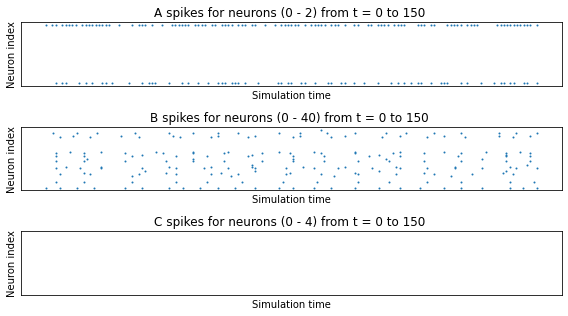

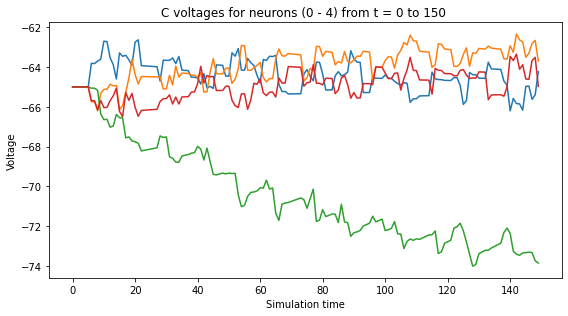

tensor([[-64.5737, -64.0191, -71.6411, -64.0169]])
3
tensor([3])


In [28]:
#plot the voltage
#reset state variables 
#network.layers["C"].thresh = -10.0 * torch.ones(nodes[2])
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()

j = idx_mis[2]
inputs = {"A":input_data[j*Time:(j*Time)+Time,:]}
network.run(inputs=inputs,time=Time)
#fetch the spikes and voltage value
spikes = {
        "A": network.monitors['A'].get('s'), 
        "B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
voltages = {#"B": network.monitors['B'].get("v"),
            "C": network.monitors['C'].get("v")}
plt.ioff()
plot_spikes(spikes)
plot_voltages(voltages, plot_type="line")
plt.show()     

print(voltages["C"][99,:,:])
print(torch.argmax(voltages["C"][99,:,:]).item())
print(s[idx_mis[0]])

# 5. Run The Validation Datasets
Test the learned network with the new generated datasets, to validate the learning capability of the network

In [130]:
#generate the dataset
SNR_dB = 18 # the SNR Value in dB
sigma2_n = 1**2 * 10**( - SNR_dB / 10 ) # get the noise variance
n = np.random.randn( N_samples ) + 1j * np.random.randn( N_samples ) #complex noise
N_validate = 50 #number of validation samples

s_val = np.random.randint(M, size= N_validate) #generate N random symbols
c_val = np.zeros(N_validate) + 1j*np.zeros(N_validate)
#generate 4 AM dataset
""" c_val = s_val * 2 + 1 #assign symbol to a certain amplitude level
n_val = np.random.normal(0,0.25,N_validate) #random gaussian noise
z_val = c_val + n_val #signal plus noise
 """
#generate 4 QAM  dataset

for i,val in enumerate(s_val):#assign symbol to certain constellation signal
    c_val[i] = qam[val] #change this to choose between psk and qam modulation scheme

n_val = np.random.randn( N_validate ) + 1j * np.random.randn( N_validate ) #complex noise
z_val = c_val + np.sqrt( sigma2_n / 2)*n_val


#convert to torch tensor
s_val = torch.from_numpy(s_val)
z_val = torch.from_numpy(z_val)

#convert into spike train
input_data_val = torch.zeros(N_validate*Time,nodes[0])
for i,val in enumerate(z_val):
    #print(i,val,y[i])
    if(mod_type=="cplx"):
        rate = torch.tensor([[(np.real(val)+1.5)*max_rate],[(np.imag(val)+1.5)*max_rate]]).squeeze()        
        #convert into poisson distributed spike train
        #input_data_val[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time)
        input_data_val[i*Time:(i*Time)+Time,:] = encode_increase_sr_2(datum=rate.int(),time=Time)
    else:
        rate = torch.tensor([[val*200],[(2*M-val)*200]]).squeeze() #convert amplitude to spike rate    
        input_data_val[i*Time:(i*Time)+Time,:] = encoding.poisson(datum=rate.int(),time=Time) 

print(z_val)
print(s_val)

tensor([-0.7436-0.5821j, -0.7352+0.6687j, -0.6424+0.7559j,  0.7043-0.7558j,
        -0.6309+0.8658j, -0.6540-0.7033j, -0.6737-0.7930j,  0.7357+0.6765j,
        -0.5599+0.6313j,  0.6081+0.7999j, -0.6666-0.7457j,  0.8516+0.5755j,
        -0.6067-0.7561j,  0.7175-0.5973j, -0.8444-0.7726j,  0.6462+0.6353j,
         0.8884+0.7276j,  0.7116+0.6227j,  0.6907+0.6915j, -0.5618-0.8545j,
        -0.5034-0.5699j, -0.5924-0.8229j,  0.6977-0.7552j,  0.7052-0.5893j,
        -0.6249-0.6995j, -0.9117+0.6209j, -0.7534-0.7277j,  0.6560-0.7647j,
        -0.5688+0.7735j,  0.7305+0.6718j,  0.7052-0.6955j,  0.6484+0.6668j,
         0.6710-0.7779j, -0.6351+0.7595j, -0.7035-0.7801j,  0.7856-0.6993j,
        -0.6773+0.7822j,  0.8329-0.6798j, -0.7431-0.6591j, -0.8069-0.6647j,
         0.7034+0.6230j,  0.5953-0.7281j, -0.6188-0.7466j, -0.8837-0.6078j,
         0.4841-0.7654j, -0.5876+0.6815j,  0.6668+0.5942j, -0.6524-0.6452j,
         0.6431-0.6452j,  0.7078-0.7764j], dtype=torch.complex128)
tensor([0, 1, 1, 2, 1

## 5.1 Run Validation data and determine the output by calculating membrane voltage

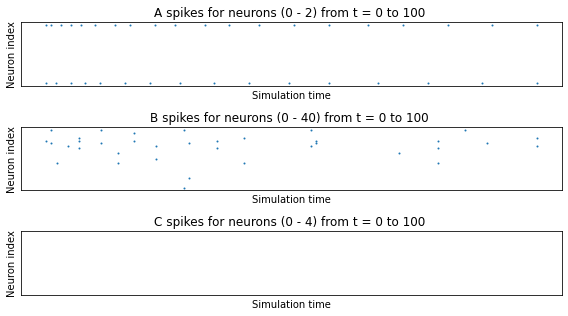

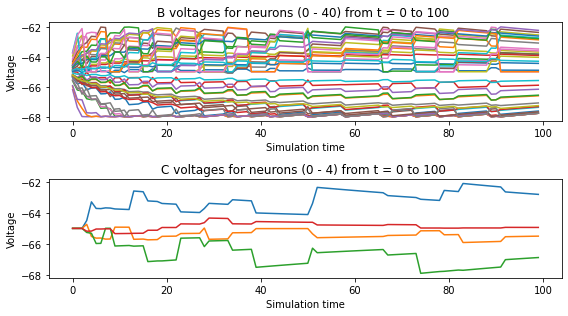

output of final layer  tensor([0., 1., 1., 2., 1., 0., 0., 3., 1., 3., 0., 3., 0., 2., 0., 3., 3., 3.,
        3., 0., 0., 0., 2., 2., 0., 1., 0., 2., 1., 3., 2., 3., 2., 1., 0., 2.,
        1., 2., 0., 0., 3., 2., 0., 0., 2., 1., 3., 0., 2., 2.])
target vector tensor([0, 1, 1, 2, 1, 0, 0, 3, 1, 3, 0, 3, 0, 2, 0, 3, 3, 3, 3, 0, 0, 0, 2, 2,
        0, 1, 0, 2, 1, 3, 2, 3, 2, 1, 0, 2, 1, 2, 0, 0, 3, 2, 0, 0, 2, 1, 3, 0,
        2, 2])
Accuracy : 100.0 % 


In [131]:
#set the membran voltage at the output layer
network.layers["C"].thresh = -10 * torch.zeros(nodes[2])
#reset state variables 
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()
#run the prediction by calculating the membrane voltage
y_pred_run = torch.zeros(N_validate)
for j in range(N_validate):
    inputs = {"A":input_data_val[j*Time:(j*Time)+Time,:]}
    network.run(inputs=inputs,time=Time)
    
    spikes = {
        "A": network.monitors['A'].get('s'), 
        "B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
    voltages = {"B": network.monitors['B'].get("v"),
                "C": network.monitors['C'].get("v")}

    if (j==0):#select random data to plot
        #plot the result
        plt.ioff()
        plot_spikes(spikes)
        plot_voltages(voltages, plot_type="line")
        plt.show()

    a_out = (network.layers['C'].v)
    y_pred_run[j] = torch.argmax(a_out)
    #print(a_out)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("output of final layer ",y_pred_run)  
print("target vector %s"%s_val)
#calculate accuracy
accr_val = (torch.sum(y_pred_run==s_val)*100/N_validate)
print("Accuracy : "+str(accr_val.item())+" % ")

## 5.2 Run Validation data and determine the output by calculating number of spike

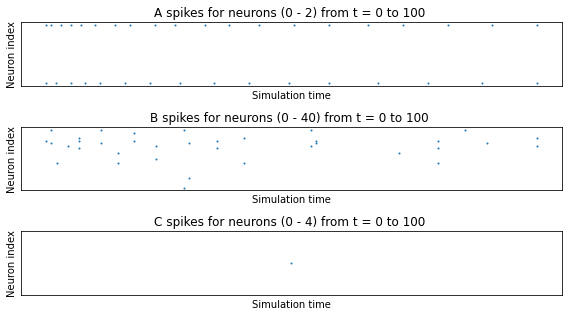

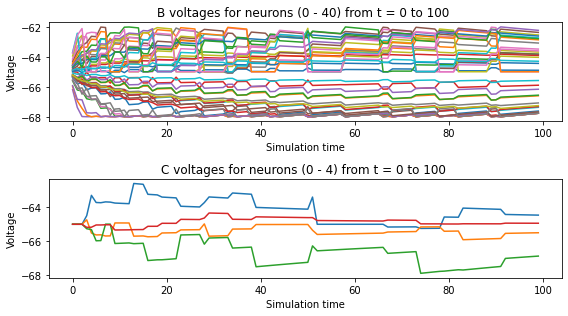

output of final layer  tensor([0., 1., 1., 2., 1., 0., 0., 3., 1., 3., 0., 3., 0., 2., 0., 3., 3., 3.,
        3., 0., 0., 0., 2., 2., 0., 1., 0., 2., 1., 3., 2., 3., 2., 1., 0., 2.,
        1., 2., 0., 0., 3., 2., 0., 0., 2., 1., 3., 0., 2., 2.])
target vector tensor([0, 1, 1, 2, 1, 0, 0, 3, 1, 3, 0, 3, 0, 2, 0, 3, 3, 3, 3, 0, 0, 0, 2, 2,
        0, 1, 0, 2, 1, 3, 2, 3, 2, 1, 0, 2, 1, 2, 0, 0, 3, 2, 0, 0, 2, 1, 3, 0,
        2, 2])
Accuracy : 100.0 % 


In [132]:
#set the membran voltage at the output layer
network.layers["C"].thresh = delta_v[torch.argmax(accuracy_vs)] * torch.ones(nodes[2])
#reset state variables 
network.layers["C"].reset_state_variables()
network.layers["B"].reset_state_variables()
#run the prediction by calculating the spike at the output layer
y_pred_run = torch.zeros(N_validate)
for j in range(N_validate):
    inputs = {"A":input_data_val[j*Time:(j*Time)+Time,:]}
    network.run(inputs=inputs,time=Time)
    spikes = {
        "A": network.monitors['A'].get('s'), 
        "B": network.monitors['B'].get("s"),
        "C": network.monitors['C'].get("s"),
    }
    voltages = {"B": network.monitors['B'].get("v"),
                "C": network.monitors['C'].get("v")}

    if (j==0):#select random data to plot
        #plot the result
        plt.ioff()
        plot_spikes(spikes)
        plot_voltages(voltages, plot_type="line")
        plt.show()
    
    
    a_out    = torch.sum(network.monitors["C"].get("s").squeeze().float(),dim=0)
    #check uniqe element in a_out
    if (sum(a_out)==0):
        y_pred_run[j] = torch.argmax(a_out,dim=0)        
    else:        
        y_pred_run[j] = (spikes["C"].squeeze().int()==1).nonzero()[0,1] #classify by determining the first spike that arrives
    #print(a_out)
    #reset state variables 
    network.layers["C"].reset_state_variables()
    network.layers["B"].reset_state_variables()

print("output of final layer ",y_pred_run)  
print("target vector %s"%s_val)
#calculate accuracy
accr_val = (torch.sum(y_pred_run==s_val)*100/N_validate)
print("Accuracy : "+str(accr_val.item())+" % ")

In [54]:
acc_valid_s.append(accr_val)
print(acc_valid_s)

[tensor(84.), tensor(90.), tensor(90.), tensor(88.), tensor(94.), tensor(94.), tensor(100.), tensor(98.)]


In [165]:
snr_db = [10,12,14,16,18,20,22,24]
""" acc_train_v = []
acc_train_s = []
acc_valid_v = []
acc_valid_s = [] """

' acc_train_v = []\nacc_train_s = []\nacc_valid_v = []\nacc_valid_s = [] '

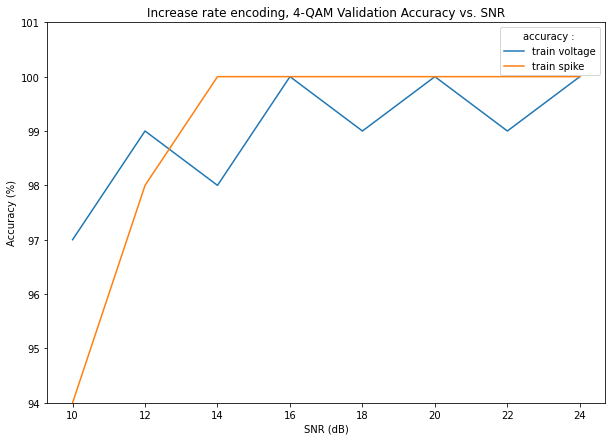

In [223]:


plt.figure(figsize=[10,7])
plt.plot(snr_db,acc_train_v,label='train voltage')
plt.plot(snr_db,acc_train_s,label='train spike')
#plt.plot(snr_db,acc_valid_v,label='valid voltage')
#plt.plot(snr_db,acc_valid_s,label='valid spike')
plt.legend(title='accuracy : ') 
plt.title('Increase rate encoding, 4-QAM Validation Accuracy vs. SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Accuracy (%)')
plt.ylim(94,101)
plt.show()